In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from itertools import chain
import re
import warnings
warnings.filterwarnings('ignore')

### Load in data
This data comes from https://hardforum.com/ where I scraped the most recent threads on Intel CPU's, AMD CPU's and GPU's, and NVIDIA GPU's. Sadly, these forums where brand specific which could bais the data towards high lift values for AMD related products. I scraped all threads that were created within the past 6 months. I used chrome web scraper extension to scrape the data. 

IMPORTANT to note is that this forum website is gaming oriented and insights should be considered accordingly

In [2]:
df7 = pd.read_csv('intel_cpu.csv', delimiter=',')
df8 = pd.read_csv('amd_cpu.csv', delimiter=',')
df9 = pd.read_csv('gpu_forum.csv', delimiter=',')
df10 = pd.read_csv('amd_gpu.csv', delimiter=',')
df11 = pd.read_csv('nvidea_gpu.csv', delimiter=',')
df12 = pd.read_csv('amd_cpu_2.csv', delimiter=',')
df13 = pd.read_csv('intel_cpu_2.csv', delimiter=',')

In [3]:
df_con = pd.concat([df7, df8, df9, df10, df11, df12, df13])

In [4]:
df = df_con[["username", "text"]]

#### Drop rows with no comments

Using web scraper, many of the comments were replies to users, in those cases many of the rows of the data just had "username said:" as the text. So these rows were dropped. After dropping these rows, we have 3,353 unique posts about CPU's and GPU's.

In [5]:
df.shape

(5560, 2)

In [6]:
df.text.head()

0    Ready4Dis said:\n\t\t\t\n\t\t\n\t\n\t\n\t\t\n\...
1    30 * 24 = 720 instead of 240\n\n\n\nso for mon...
2         I'd love to get a 9900 for $220...any links?
3                        where did you guys buy them ?
4    I was hopeful, because I have an Intel DQ57TM ...
Name: text, dtype: object

In [7]:
def drop_said(s):
    if str(s).find("said:") >= 0:
        return "nan"
    else:
        return s

In [8]:
df["text"] = df.text.map(drop_said)

In [9]:
df = df[df["text"] != "nan"]
df.head()

,username,text
1,adrhc,30 * 24 = 720 instead of 240\n\n\n\nso for mon...
2,/dev/null,I'd love to get a 9900 for $220...any links?
3,drklu,where did you guys buy them ?
4,DeeVeeDee,"I was hopeful, because I have an Intel DQ57TM ..."
12,III_Slyflyer_III,"Still running my 5930K @ 4.5Ghz (1.33vCore, 1...."


In [10]:
df.shape

(3353, 2)

## NLP preprocessing 
Before regular NPL preprocessing steps I needed to change some of the wide variety of names for one product that were used in the forums. For example, I changed 2080ti to 2080 becuase some users used 2080 and some used 2080ti. There are many of these that I have not changed yet but it is very tedius and would not effect the overall results much.

In [11]:
df["text"] = df["text"].astype(str).map(lambda x: x.lower())

In [12]:
%%time
# change product names example: ryzen 5 -> ryzen5
df["text"] = df["text"].map(lambda x: x.replace(" ti", "ti"))
df["text"] = df["text"].map(lambda x: x.replace("2080ti", "2080"))
df["text"] = df["text"].map(lambda x: x.replace("1080ti", "1080"))
df["text"] = df["text"].map(lambda x: x.replace("3900x", "3900"))
df["text"] = df["text"].map(lambda x: x.replace("3600x", "3600"))
df["text"] = df["text"].map(lambda x: x.replace("3950x", "3950"))

# tokenization = split sentences into word strings
df['tokens'] = df['text'].map(nltk.word_tokenize)
df['tokens'] = df['tokens'].map(lambda x: set(x))

# lemmatization = converting a word to its base form, different from stemming
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df ['tokens'].map(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['lemmatized'] = df['lemmatized'].map(lambda x: set(x))

# remove stop words
stop_words = set(stopwords.words('english'))
df['processed'] = df['lemmatized'].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove punctuations
punc = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df['processed'] = df['processed'].map(lambda x: [word for word in x if word.lower() not in punc])

# remove some other stuff and return lower case
others = ["''", "``", "n't", "l", "oh", "lol", "'m", "'s", "since"]
df['processed'] = df['processed'].map(lambda x: [word.lower() for word in x if word.lower() not in others])

Wall time: 7.79 s


#### These are the most frequent words in the comments and it is where I got all the brands and products from

In [13]:
pd.set_option('display.max_rows', 4200)

#create [[str, str,...] ...] and chain(*) returns each str in each list 
all_words = pd.Series(chain(*list(df['processed']))) 
word_frequency = all_words.value_counts()
word_frequency[:600]

nan                  707
wa                   555
cpu                  511
would                469
like                 459
get                  452
one                  381
core                 354
new                  334
http                 324
still                308
ha                   306
game                 303
even                 301
also                 299
see                  292
amd                  285
intel                283
card                 269
much                 265
go                   264
really               262
good                 254
well                 248
need                 246
going                237
think                233
doe                  231
use                  228
year                 225
want                 225
run                  222
system               220
gpu                  217
gaming               216
work                 210
could                209
better               209
upgrade              208
running              206


In [25]:
#brands = ["3900", "3600", "x570", "3950", "i5", "i7", "2080", "1080", "msi" "xeon", "intel", "amd", "nvidia", "ryzen", "pro", "i9"]
brands = ["3900", "3600", "x570", "3950", "i5", "i7", "2080", "1080","xeon", "pro", "i9", "5700"] # products
#brands = ["radeon", "rx", "geforce", "rtx"] # gpu brands
#brands = ["5700", "5600", "5500", "2080", "1080"] # gpu products
#brands = ["pro", "quadro", "xeon"] # workstation products
tmp = pd.DataFrame(word_frequency)
tmp['word'] = word_frequency.index
mask = tmp['word'].isin(brands)
brand_frequency = word_frequency[mask]
top_brands = brand_frequency
print("Freq of workstation products")
top_brands

Freq of workstation products


2080    105
3900    103
3600     94
1080     72
pro      59
xeon     51
x570     51
3950     50
i7       45
i5       21
i9       16
5700     15
dtype: int64

### Frequency analysis
- Based on these brand/product frequencies, I am suprised that i7 and i5 are so infrequently used. The 3900 or ryzen 9 is mentioned 6x more than i9 which is its competitor. 
- nvidia gpu's are discussed 10 fold more than amd gpu's when it comes to specific gpu and brand name
- amd's prefessional gpu the radeon pro is talked about much more than nvidea's quadro

In [26]:
def lift(a, b):
    N = df['processed'].shape[0]
    N_ab = sum(df['processed'].map(lambda x: a in x and b in x))
    N_a = sum(df['processed'].map(lambda x: a in x))
    N_b = sum(df['processed'].map(lambda x: b in x))
    return(N*N_ab/(N_a*N_b))

## Below is the lift analysis comparing all the brands and products
Some products where never mentioned with other products so to be able to use the mds plot I replaced 0 lift with 1.

In [27]:
lift_brands = pd.DataFrame(top_brands.index.values, columns=['brands']) #initialize df 
for brand in top_brands.index.values:
    lift_brands[brand] = lift_brands['brands'].map(lambda x: lift(x, brand)) #create lift column for each candidate 
lift_brands = lift_brands.set_index('brands')
lift_brands = lift_brands.replace(0, 1)
lift_brands

,2080,3900,3600,1080,pro,xeon,x570,3950,i7,i5,i9,5700
brands,,,,,,,,,,,,
2080,31.933333,2.480259,1.019149,8.426852,3.788701,1.000000,3.130719,1.277333,0.709630,1.520635,1.995833,1.000000
3900,2.480259,32.553398,3.809440,1.356392,1.655258,1.000000,8.297925,12.370291,1.446818,1.000000,2.034587,1.000000
3600,1.019149,3.809440,35.670213,0.990839,1.813740,1.000000,7.693575,1.426809,2.378014,3.397163,1.000000,4.756028
1080,8.426852,1.356392,0.990839,46.569444,3.157250,1.000000,0.913126,1.000000,3.104630,6.652778,2.910590,1.000000
pro,3.788701,1.655258,1.813740,3.157250,56.830508,3.342971,4.457295,3.409831,6.314501,2.706215,7.103814,3.788701
xeon,1.000000,1.000000,1.000000,1.000000,3.342971,65.745098,1.000000,2.629804,11.688017,1.000000,1.000000,1.000000
x570,3.130719,8.297925,7.693575,0.913126,4.457295,1.000000,65.745098,11.834118,4.383007,1.000000,4.109069,4.383007
3950,1.277333,12.370291,1.426809,1.000000,3.409831,2.629804,11.834118,67.060000,2.980444,1.000000,8.382500,1.000000
i7,0.709630,1.446818,2.378014,3.104630,6.314501,11.688017,4.383007,2.980444,74.511111,10.644444,4.656944,1.000000


# MDS plot
Multidimensional scaling (MDS) is a popular approach for graphically representing relationships between objects (i.e. brands or products) in multidimensional space. Dimension reduction via MDS is achieved by taking the original set of samples (lifts) and calculating a dissimilarity (distance) measure for each pairwise comparison of samples. The samples are then represented graphically in two dimensions such that the distance between points on the plot approximates their multivariate dissimilarity as closely as possible.

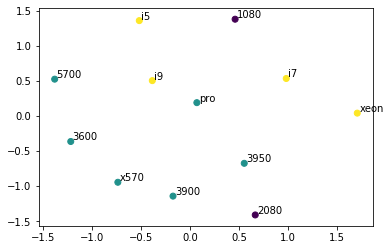

In [46]:
inverse_lift_candidates = lift_brands.apply(lambda x: 1/x)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
%matplotlib inline  

embedding = MDS(n_components=2, random_state=10)
mds = embedding.fit_transform(inverse_lift_candidates)
mds_output = pd.DataFrame(mds, index=inverse_lift_candidates.index.values, columns=['x', 'y'])
brands = [1, 2, 2, 1, 2, 3, 2, 2, 3, 3, 3, 2]
mds_output["brands"] = brands

fig, ax = plt.subplots()
scatter = ax.scatter(mds_output['x'], mds_output['y'], c = mds_output["brands"])


for candidate in inverse_lift_candidates.index.values:
    ax.text(mds_output.loc[candidate, 'x']+0.02, mds_output.loc[candidate, 'y']+0.02, candidate)

In [30]:
mds_output

,x,y,brands
2080,0.663411,-1.411332,1
3900,-0.175804,-1.142700,2
3600,-1.219233,-0.363729,2
1080,0.457890,1.380572,1
pro,0.067495,0.190472,2
xeon,1.704542,0.041093,3
x570,-0.738662,-0.945197,2
3950,0.551072,-0.674859,2
i7,0.979684,0.535016,3
i5,-0.519900,1.360556,3


# Insights
### 1) The older 1080ti is compared to intel cpu's much more than amd cpu's 
### 2) The newer 2080ti, the future of gaming, is slightly more compared with amd cpu's than intel